# 1. Exploratory data analysis

1. We have a regression task of predicting the age of a person from reading its picture.
2. We will use ResNet50 to train the ImageNet dataset.
3. We will have 1 neoron output, using ReLU to get a positive prediction, bigger than 1.
4. We will use either MSE or MAE for the loss function.

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image

In [3]:
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls %'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    df_nulls = df_nulls.sort_values("Percent of Nulls %",ascending=False)
    return df_nulls

def explore(df):
    df = df
    print(df.head())
    print("Number of duplicated rows",df.duplicated().sum())
    print("Data shape",df.shape)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    display(df.info())
    display(df.describe())
    print("Number of duplicated rows")
    display(df.duplicated().sum())
    temp_raw_data=df.copy()
    fig = plt.figure(figsize = (7,10))
    ax = fig.gca()
    temp_raw_data.hist(ax = ax)
    fig = ax.get_figure()

In [17]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Number of duplicated rows 0
Data shape (7591, 2)
Columns with nulls:


,Missing Values,Percent of Nulls %
file_name,0,0.0
real_age,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Number of duplicated rows


0

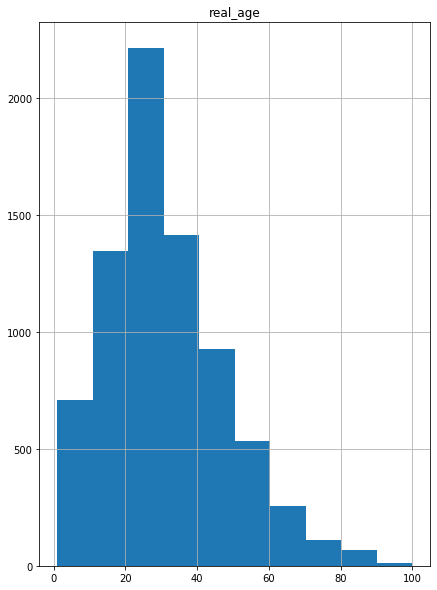

In [5]:
explore(labels)

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that target feature distribution was explored and visualized.
</div>

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please, visualize some photos from dataset.
    <br> Don't forget to provide some findings about: dataset size, target feature distribution, dataset structure.
</div>
I think everything is printed in the cell... but I will seperated if needed...

In [13]:
# dataset size
print(labels.shape)

(7591, 2)


In [14]:
# dataset info
display(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

In [16]:
# dataset info
display(labels.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Age: 4


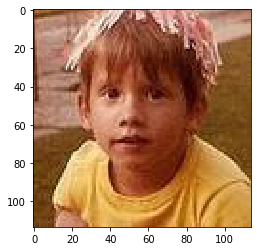

In [38]:
# showing some pictures
image0 = Image.open('/datasets/faces/final_files/000000.jpg')
print('Age:', labels['real_age'][0])
plt.imshow(image0)

Age: 18


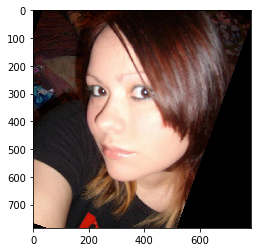

In [46]:
image1 = Image.open('/datasets/faces/final_files/000001.jpg')
print('Age:', labels['real_age'][1])
plt.imshow(image1)

Age: 80


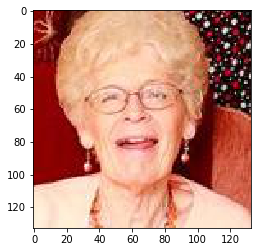

In [47]:
image2 = Image.open('/datasets/faces/final_files/000002.jpg')
print('Age:', labels['real_age'][2])
plt.imshow(np.array(image2))

# 2. Model training

Transfer the model training code and the result of printing on the screen here.


(The code in this section is run on a separate GPU platform, so it is not designed as a cell with a code, but as a code in a text cell)

In [9]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

In [7]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

In [8]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

## Results

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 109s - loss: 227.3241 - mae: 11.4125 - val_loss: 341.1217 - val_mae: 13.7239

Epoch 2/20
356/356 - 45s - loss: 143.4116 - mae: 9.1275 - val_loss: 280.4819 - val_mae: 12.6657

Epoch 3/20
356/356 - 45s - loss: 117.9886 - mae: 8.3317 - val_loss: 190.5408 - val_mae: 10.3402

Epoch 4/20
356/356 - 45s - loss: 103.1975 - mae: 7.7348 - val_loss: 108.7702 - val_mae: 8.0041

Epoch 5/20
356/356 - 45s - loss: 88.1287 - mae: 7.2127 - val_loss: 239.5398 - val_mae: 11.5738

Epoch 6/20
356/356 - 45s - loss: 76.4698 - mae: 6.7699 - val_loss: 103.4752 - val_mae: 7.7652

Epoch 7/20
356/356 - 44s - loss: 64.3668 - mae: 6.1964 - val_loss: 138.0538 - val_mae: 9.4710

Epoch 8/20
356/356 - 45s - loss: 57.4973 - mae: 5.7784 - val_loss: 227.5172 - val_mae: 11.5011

Epoch 9/20
356/356 - 45s - loss: 52.3373 - mae: 5.5643 - val_loss: 117.4339 - val_mae: 8.5282

Epoch 10/20
356/356 - 45s - loss: 42.6713 - mae: 5.0589 - val_loss: 101.9650 - val_mae: 7.5139

Epoch 11/20
356/356 - 45s - loss: 34.3145 - mae: 4.5253 - val_loss: 90.9673 - val_mae: 7.0868

Epoch 12/20
356/356 - 45s - loss: 32.3351 - mae: 4.4171 - val_loss: 104.3543 - val_mae: 7.8612

Epoch 13/20
356/356 - 44s - loss: 34.7111 - mae: 4.5385 - val_loss: 198.5084 - val_mae: 11.2949

Epoch 14/20
356/356 - 45s - loss: 26.2728 - mae: 3.9435 - val_loss: 99.6143 - val_mae: 7.6237

Epoch 15/20
356/356 - 45s - loss: 21.3551 - mae: 3.5896 - val_loss: 87.5394 - val_mae: 7.0676

Epoch 16/20
356/356 - 44s - loss: 20.2174 - mae: 3.4729 - val_loss: 83.2875 - val_mae: 6.9546

Epoch 17/20
356/356 - 45s - loss: 19.5660 - mae: 3.3927 - val_loss: 84.3765 - val_mae: 7.0528

Epoch 18/20
356/356 - 44s - loss: 21.1413 - mae: 3.5643 - val_loss: 94.5341 - val_mae: 7.4474

Epoch 19/20
356/356 - 45s - loss: 19.0488 - mae: 3.3836 - val_loss: 81.7175 - val_mae: 6.7933

Epoch 20/20
356/356 - 44s - loss: 19.2448 - mae: 3.3430 - val_loss: 106.3161 - val_mae: 7.8036



119/119 - 11s - loss: 106.3161 - mae: 7.8036
#### Test MAE: 7.8036

# 3. Trained model analysis

Test MAE value is of 7.8036. Most of the people where on the range of 10 years from there real age.

Our model acheived good MAE value also for 11 epochs, meaning we could save time of training and running the model with less epochs.

Our MAE value is not far from the value achieved on the article.

Our model used MSE as loss function. ResNet50 worked well, without introducing more special layers.

ReLU is must at the output layer for predicting the age.